In [77]:
%matplotlib inline


import pandas as pd
import seaborn as sns
from scipy.stats import ttest_ind, ttest_ind_from_stats
import matplotlib.pyplot as plt
plt.style.use('ggplot')
sns.set_style("whitegrid")
MLB_Data_162 = pd.read_csv('MLBData_FG_162.csv')
MLB_Data_162['Season'] = MLB_Data_162.Season.apply(lambda x: x.replace("Gamelogs\GL","").replace(".TXT", ""))
MLB_Data_162_2 = pd.read_csv('MLB_Data_162_2.csv')

MLB_Data_162_2['Season'] = MLB_Data_162_2.Season.apply(lambda x: x.replace("Gamelogs\GL","").replace(".TXT", ""))
MLB_Data_162_2['winning_per_from_mean_fake'] = MLB_Data_162_2.winning_per_fake.apply(lambda x: abs(x - .5))
MLB_Data_162_2['winning_per_from_mean_real'] = MLB_Data_162_2.winning_per_real.apply(lambda x: abs(x - .5))
#print(MLB_Data_162.head())
MLB_Data_10k = pd.read_csv('MLBData_FG_10k.csv')
MLB_Data_10k['Season'] = MLB_Data_10k.Season.apply(lambda x: x.replace("Gamelogs\GL","").replace(".TXT", ""))
MLB_Data_10k_1h = pd.read_csv('MLB_Data_10K_Half_Season.csv')
MLB_Data_10k_2h = pd.read_csv('MLB_Data_10K_2nd_Half_Season.csv')


In [78]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# Do MLB teams really go "Hot" and "Cold"?




### Project Description:

During a baseball season, teams can go on streaks of winning or losing. These streaks can be quite long, reaching more then 20 games on occasion. During these streaks fans will claim that their team is "hot" or "on a roll" if they are winning and that the team is "cold" or in a slump" if they are losing.

However, I want to know whether this "streak effect" is a real factor or rather simply a product of overactive pattern recognition on the part of the fans. More precisely, I want to examine whether or not these streaks are based on a simple combination of overall season-long team stength and random chance or if factors which influence recent performance also impact win/loss outcomes seperately from season-long team strength.

To start investigating this question, I have compiled all the gamelogs from the 1960 season on found on http://www.retrosheet.org/. I also created simulated seasons created with a random number generator weighted by each teams real final Winning Percentage at the end of their season. I combined the aggregate Winning Percentage of the real and simulated seasons in a datset mapped by team and season. 

Also included in the data-set is a metric I created called "Average Streak Size". This metric measures the streakiness of each real and simulated team per season. In this writeup, I will compare the Average Streak Size in the real data to that in the simulated data to see if there are any interesting or significant differences. 


### Average Streak Size

To understand Average Streak Size metric, imagine if a team, in a six game season had streaks like:
* Won 3 games 'WWW'
* Lost two games 'LL'
* Then won their final game 'W'. 

The Average Streak Size for this hypothetical team in this hypothetical season would be the length of the season(6 games) divided by the number of streaks(3) for an Average Streak Size of 2.0. 

If another hypothetical team won all their games('WWWWWW') they would have 1 streak for 6 games, giving that team an Average Streak size of 6 / 1 = 6.0.



### Simulated Seasons

The simulated seasons are created using a random number generator that will return wins or losses based on the teams real final winning percentage that season. I expect that the distance of each teams winning percentage per season from .500 (the winning percentage if a team were to lose and win exactly half of their games) will be highly correlated to streak size. This is because teams which are farthest from .500 will have a higher percentage of either wins or losses, so they should switch less between winning and losing resulting in a higher Average Streak Size. 

Because of this possible correlation, I will make the simulated seasons long(10,000 games). Making the simulated season this long will ensure that the random variations in the Winning Percentages get smoothed out over the long-term and that the simulated teams have winning percentages closer to the teams that they are simulating as a result.  

The downside to using the real winning percentages to create the simulated data is that if there is a "streak effect" which effects the real winning percentage, we should expect the "streak effect" to change the simulated winning percentage as well. This will make it more difficult to find differences between the real and simulated data.  

Despite this downside, if there are "streak effects" for both winning and losing, both the winning "streak effect" and losing "streak effect" should cancel each other out in terms of real winning percentage to some extent. For example, a extremely streaky team could win 81 games in a row then lose 81 games in a row for a final Winning Percentage of .500, and an Average Streak Size of 81. If I were to simulate this season based on the final .500 winning percentage I would probably end up with a simulated winning percentage very close to .500, but a streak size far smaller the 81. 

Because of this cancellation, if "streak effect"s are real, for a given winning percentage we should expect that the Average Streak Size in the real data will be greater then in the simulated data.

## Data Sets:

For context, I have included a print out of the first 10 rows of the data set, which includes real and 10,000 game simulated seasons below

In [79]:
MLB_Data_10k_diplay = MLB_Data_10k
MLB_Data_10k_diplay =MLB_Data_10k_diplay.rename(columns = {'avg_streak_fake':'Avg Sim Streak Size', 'avg_streak_real' : 'Avg Real Streak Size'})
MLB_Data_10k_diplay =MLB_Data_10k_diplay.rename(columns = {'winning_per_fake':'Sim Winning %', 'winning_per_real' : 'Real Winning %'})
MLB_Data_10k_diplay =MLB_Data_10k_diplay.rename(columns = {'wp_from_mean_fake':'Sim |Winning % - .5|', 'wp_from_mean_real' : 'Real |Winning % - .5|'})
MLB_Data_10k_diplay =MLB_Data_10k_diplay.rename(columns = {'team':'Team'})

col_order = ['Season', 'Team', 'Avg Real Streak Size', 'Avg Sim Streak Size', 'Real Winning %', 'Sim Winning %', 'Real |Winning % - .5|', 'Sim |Winning % - .5|' ]
MLB_Data_10k_diplay[col_order].head(10)


,Season,Team,Avg Real Streak Size,Avg Sim Streak Size,Real Winning %,Sim Winning %,Real |Winning % - .5|,Sim |Winning % - .5|
0,1960,PHI,2.109589,2.120441,0.383117,0.3892,0.116883,0.1108
1,1960,CHN,1.949367,2.076843,0.389610,0.3830,0.110390,0.1170
2,1960,PIT,2.231884,2.114165,0.616883,0.6204,0.116883,0.1204
3,1960,SLN,2.109589,2.032107,0.558442,0.5678,0.058442,0.0678
4,1960,MLN,1.878049,2.039984,0.571429,0.5722,0.071429,0.0722
5,1960,CIN,1.974359,2.040816,0.435065,0.4331,0.064935,0.0669
6,1960,BOS,2.200000,2.040400,0.422078,0.4236,0.077922,0.0764
7,1960,WS1,2.138889,2.004008,0.474026,0.4735,0.025974,0.0265
8,1960,NYA,2.298507,2.115059,0.629870,0.6329,0.129870,0.1329
9,1960,KC1,2.081081,2.139037,0.376623,0.3773,0.123377,0.1227


## Data Results: 


### Winning Percentage distance from .500 vs. Average Streak Size

Looking at the real data, |Winning % - .5| vs. Average Streak Size has a weaker correlation then I expected with at 0.31. The surprisingly weak correlation appears to be due mostly due to the fact that randomness has a larger impact on Average Streak Size when there are fewer games. For instance, when we use the simulated data which has 10,000 games per team per season the correlation is very strong at .87

When the simulated number of games per team per season drops down to 162, the correlation drops again to 0.42. This is much weaker then the correlation observed with simulated 10K game seasons, but still significantly larger then the .31 correlation in the real data.

The difference between the correlations in the real and 162 game season simulated data supports the idea that there could be a real "streak effect" which is a factor in the correlation between |Winning % - .5| and Average Streak Size in the real data, but is not a factor in the simulated data.

I ran a couple more 162 game season simulations and got correlations of .397 and .409 which are fairly close to the orignial 162 game season simulation correlation of .42, so this differences do not appear to be as a result of random flucuations in the data.  


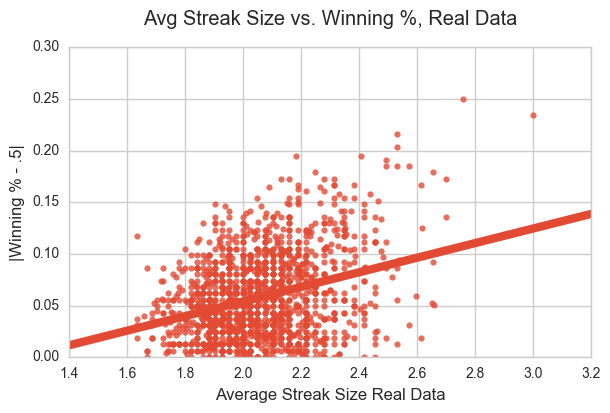

In [80]:
#print(MLB_Data_162.head())
corr = MLB_Data_162.corr()
#print(corr)


sns.despine()
ax = sns.regplot(MLB_Data_162.avg_streak_real, MLB_Data_162.wp_from_mean_real, ci=None)
ax.set_ylim(ymin=0)
ax.set_title('Avg Streak Size vs. Winning %, Real Data').set_position([.5, 1.05])

ax.set(xlabel='Average Streak Size Real Data', ylabel='|Winning % - .5|')

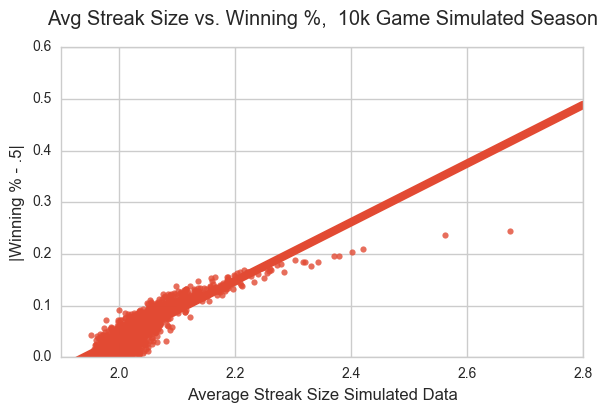

In [81]:
#print(MLB_Data_162.head())
corr = MLB_Data_10k.corr()
#print(corr)


sns.despine()
#print(MLB_Data_10k.head())
ax = sns.regplot(MLB_Data_10k.avg_streak_fake, MLB_Data_10k.wp_from_mean_fake, ci=None)
ax.set_ylim(ymin=0)
ax.set_title('Avg Streak Size vs. Winning %,  10k Game Simulated Season').set_position([.5, 1.05])

ax.set(xlabel='Average Streak Size Simulated Data', ylabel='|Winning % - .5|')

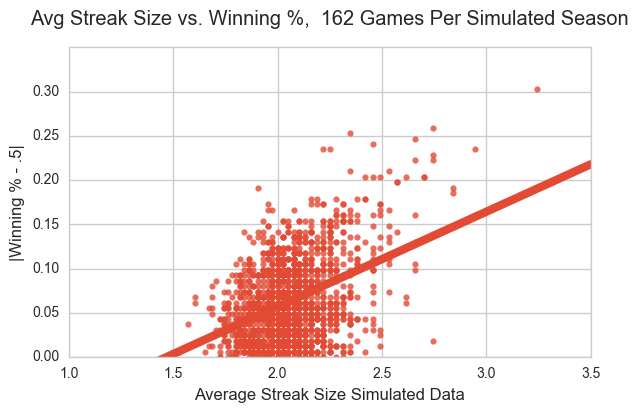

In [82]:
#print(MLB_Data_162.head())
corr = MLB_Data_162.corr()
#print(corr)


sns.despine()
ax = sns.regplot(MLB_Data_162.avg_streak_fake, MLB_Data_162.wp_from_mean_fake, ci=None)
ax.set_ylim(ymin=0)
ax.set_title('Avg Streak Size vs. Winning %,  162 Games Per Simulated Season').set_position([.5, 1.05])

ax.set(xlabel='Average Streak Size Simulated Data', ylabel='|Winning % - .5|')

### Average Streak Size Means and Significance

When looking at the data in aggreagate, the mean Average Streak Size of real and simulated data are very close, with the real data less then one-percent larger then the simulated data. 

However, the difference does appear to be real and not a result of pure chance. By using Welch's t-test to compare the means, we can determine that the chances that the true means of both the real and simulated are equal is <.1%. This indicates that the differences in the means, although small in terms of absolute percentages is far below the standard 5% threshold for significance.



In [83]:
print("\nAverage Streak Size Real Data:", MLB_Data_10k.avg_streak_real.mean())

print("\nAverage Streak Size Randomly Created Data, 10k Games: ", MLB_Data_10k.avg_streak_fake.mean())

t, p = ttest_ind(MLB_Data_10k.avg_streak_fake, MLB_Data_10k.avg_streak_real, equal_var=False)
print("")
print ("P Value =", p)






Average Streak Size Real Data: 2.0598037786152767

Average Streak Size Randomly Created Data, 10k Games:  2.0425862569028133

P Value = 0.000442587273321


## Conclusion:
The means of the real and simulated data are too close to make any firm conlusions, but there does appear to be a small "streak effect" present. The difference in correlation between |Winning percentage - .5| and Average Streak Size in the simulated 162 Game Seasons and the real 162 game seasons supports this conclusion.

However, effects of injuries and midseason trades in the baseball season could be potential confounding factors as I would not consider the effect of inuries and trades as the same as a true "streak effect". The factor I discussed earlier where the teams streakiness determines its winning percentage must be taken into account as well. Also, if the "streak effect" was real, further investigation would be needed to figure out the cause of the effect.

## Next Steps:

Next I plan on seeing if taking into account recent past performance has any predicitve validity. In other words I want to see if  ateams record in the past 5, 10, 20 etc. games would be more predictive of their next game then performance over the entire season. 
